In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
  
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [19]:
link = 'https://drive.google.com/file/d/100u7lqFVWXRH4edZmRvz0-XzheemykoJ/view'

In [21]:
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('delayed.csv')  
  
df = pd.read_csv('delayed.csv')
print(df)

         Unnamed: 0  ActualElapsedTime  ...      dest  carrier_me
0                 0                128  ...  0.011703   30.087884
1                 1                128  ...  0.011703   30.087884
2                 2                 96  ...  0.015288   30.087884
3                 3                 90  ...  0.015288   30.087884
4                 4                101  ...  0.004950   30.087884
...             ...                ...  ...       ...         ...
1936753     1936753                147  ...  0.055194   39.881507
1936754     1936754                127  ...  0.055194   39.881507
1936755     1936755                162  ...  0.022669   39.881507
1936756     1936756                115  ...  0.055194   39.881507
1936757     1936757                123  ...  0.055194   39.881507

[1936758 rows x 24 columns]


In [22]:
df=df.drop(['Unnamed: 0'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936758 entries, 0 to 1936757
Data columns (total 23 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ActualElapsedTime  int64  
 1   AirTime            int64  
 2   ArrDelay           int64  
 3   DepDelay           float64
 4   Distance           float64
 5   TaxiIn             float64
 6   TaxiOut            float64
 7   Cancelled          float64
 8   Diverted           int64  
 9   CarrierDelay       float64
 10  WeatherDelay       float64
 11  NASDelay           float64
 12  SecurityDelay      float64
 13  LateAircraftDelay  float64
 14  DepTime_sin        float64
 15  DepTime_cos        float64
 16  Month_sin          float64
 17  Month_cos          float64
 18  DayOfWeek_sin      float64
 19  DayOfWeek_cos      float64
 20  origin_freq        float64
 21  dest               float64
 22  carrier_me         float64
dtypes: float64(19), int64(4)
memory usage: 339.9 MB


In [23]:
from sklearn.model_selection import train_test_split
X,y = df.loc[:, df.columns != 'ArrDelay'],df.loc[:, df.columns == 'ArrDelay']

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [24]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=8).fit(X_train, y_train,)

Profundidad del árbol: 8
Número de nodos terminales: 254


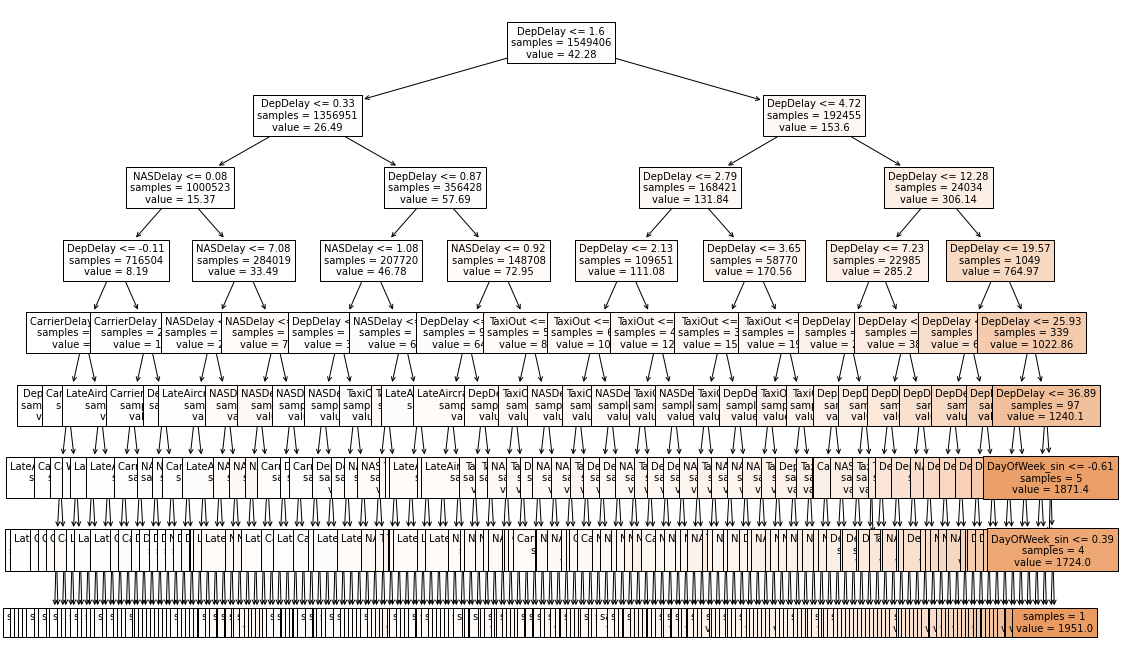

In [25]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(18, 12))

print(f"Profundidad del árbol: {model.get_depth()}")
print(f"Número de nodos terminales: {model.get_n_leaves()}")

plot = plot_tree(
            decision_tree = model,
            feature_names = df.drop(columns = "ArrDelay").columns,
            class_names   = 'ArrDelay',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

In [27]:
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
param_grid = {"min_samples_split": [10, 20, 40],
              "max_depth": [6, 8],
              "min_samples_leaf": [20, 40],
              "max_leaf_nodes": [5, 20],
              }

## Comment in order to publish in kaggle.

grid_cv_model = GridSearchCV(model, param_grid, cv=5)

grid_cv_model.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=8, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [6, 8], 'max_leaf_nodes': [5, 20],
                         'min_samples_leaf': [20, 40],
                         'min_

In [29]:
  print("R-Squared::{}".format(grid_cv_model.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_model.best_params_))

R-Squared::0.9355306505095861
Best Hyperparameters::
{'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 20, 'min_samples_split': 10}


In [30]:
df1 = pd.DataFrame(data=grid_cv_model.cv_results_)
df1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.065825,0.051759,0.044565,0.000514,6,5,20,10,"{'max_depth': 6, 'max_leaf_nodes': 5, 'min_sam...",0.809375,0.810682,0.803969,0.815117,0.81504,0.810837,0.004131,13
1,5.027732,0.047382,0.045291,0.002114,6,5,20,20,"{'max_depth': 6, 'max_leaf_nodes': 5, 'min_sam...",0.809375,0.810682,0.803969,0.815117,0.81504,0.810837,0.004131,13
2,5.079313,0.029524,0.045101,0.001139,6,5,20,40,"{'max_depth': 6, 'max_leaf_nodes': 5, 'min_sam...",0.809375,0.810682,0.803969,0.815117,0.81504,0.810837,0.004131,13
3,5.098737,0.038965,0.044279,0.000489,6,5,40,10,"{'max_depth': 6, 'max_leaf_nodes': 5, 'min_sam...",0.809375,0.810682,0.803969,0.815117,0.81504,0.810837,0.004131,13
4,5.096704,0.015721,0.044610,0.000486,6,5,40,20,"{'max_depth': 6, 'max_leaf_nodes': 5, 'min_sam...",0.809375,0.810682,0.803969,0.815117,0.81504,0.810837,0.004131,13


[Text(0.5, 1.0, 'Effect of Depth and Leaf Nodes on Model Performance')]

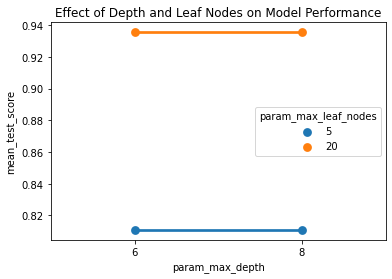

In [31]:
fig,ax = plt.subplots()
sns.pointplot(data=df1[['mean_test_score',
                           'param_max_leaf_nodes',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_max_leaf_nodes',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")